# Rainbowgrams

As mentioned in the [exploration of perceptible and imperceptible phase manipulations](https://github.com/JohnVinyard/notebooks/blob/master/audiometric/audiometric.ipynb), phase contributes quite a bit to our perception of sound, _in some cases_.

The [NSynth paper](https://arxiv.org/abs/1704.01279) introduces(?) a pretty cool way to visualize both the magnitudes and phases of a spectrogram, which isn't something I had seen before.  They apply a few manipulations to get a consistent-over-time measure of phase, and then apply a color map so that brightness corresponds to magnitude (as usual), and _color_ corresponds to phase!

This notebook is a quick overview of how to compute the rainbowgram.

## Compute the Short-Time Fourier Transform

First, we'll start with the good old short-time fourier transform that we know and love.

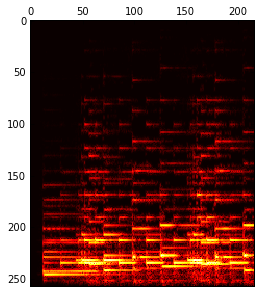

In [32]:
%matplotlib inline
import zounds
from zounds.spectral import apply_scale
from zounds.loudness import unit_scale
from matplotlib import pyplot as plt
import numpy as np
from time import time

samplerate = zounds.SR11025()
BaseModel = zounds.stft(
    resample_to=samplerate, 
    store_fft=True)

@zounds.simple_in_memory_settings
class Sound(BaseModel):
    pass


_id = Sound.process(meta='../audio/bach.ogg')
snd = Sound(_id)

time_slice = zounds.TimeSlice(duration=zounds.Seconds(5))
fft = np.array(snd.fft[time_slice])
fft = np.abs(fft)
fft = zounds.log_modulus(fft * 1000)

plt.matshow(np.rot90(fft), cmap='hot')

## Do Some Phase Wrangling

The angles of the phases returned from [`np.fft.rfft`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.fft.rfft.html) don't tend to be very coherent over time, so we'll need to do a little further massaging to get what we need.

In [33]:
def rainbowgram(time_frequency_repr, colormap, unwrap_phase=False):
    """
    Compute an array that encodes FFT magnitudes as brightness,
    and phase as color
    """
    
    # magnitudes on a log scale, and shifted and 
    # scaled to the unit interval
    magnitudes = np.abs(time_frequency_repr.real)
    magnitudes = zounds.log_modulus(magnitudes * 1000)
    magnitudes = unit_scale(magnitudes)

    # get the angles of the phases in radians, and
    # optionally unroll
    angles = np.angle(time_frequency_repr)
    if unwrap_phase:
        angles = np.unwrap(angles, axis=0)
        angles = np.gradient(angles)[0]
    angles = unit_scale(angles)

    # apply the colormap to translate phase angles
    # into RGBA values
    colors = colormap(angles)
    colors *= magnitudes[..., None]

    # exclude the alpha channel, if there is one
    colors = colors[..., :3]
    
    arr = zounds.ArrayWithUnits(
        colors, time_frequency_repr.dimensions + (zounds.IdentityDimension(),))
    return arr

Below, we'll compute the rainbowgram without unwrapping phase.  We can't see the constant colors we'd expect during a musical note, but we can pretty clearly see some repeating checkerboard patterns, which strongly suggests that the phases are repeatedly "wrapping" back around (since the allowable range here is `[-pi, pi]`.

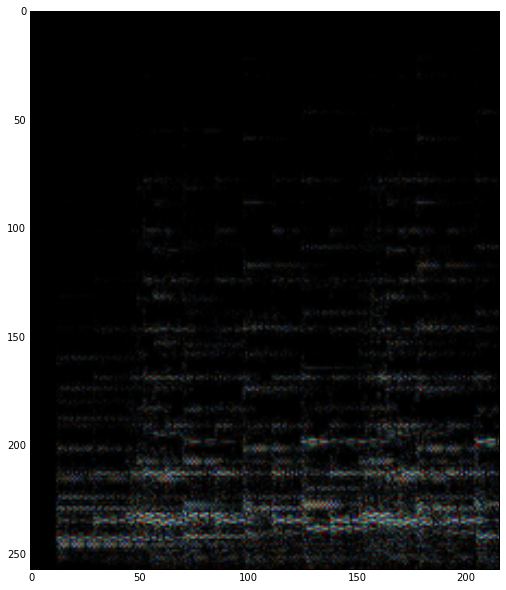

In [34]:
from matplotlib import cm

colors = rainbowgram(snd.fft, cm.rainbow)
colors = np.array(colors[time_slice])

fig = plt.figure()
fig.set_size_inches((10, 10))
plt.imshow(np.rot90(colors))

The NSynth paper suggests that we take two steps to alleviate the wrapping issue, and get plots that fit better with our intuition, and are also more aesthetically pleasing.

1. unwrap the phase, removing discontinuties greater than `pi`.  We can use [`np.unwrap`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unwrap.html) for this.
2. Now, we'll have numbers far outside the allowable `[-pi, pi]` range, but if we then take the numerical gradient, again, conveniently using [`np.gradient`](https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.gradient.html#numpy.gradient).

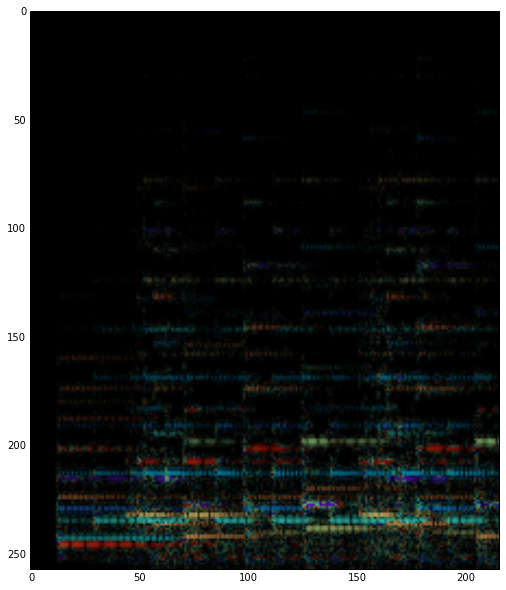

In [35]:
from matplotlib import cm

colors = rainbowgram(snd.fft, cm.rainbow, unwrap_phase=True)
colors = np.array(colors[time_slice])

fig = plt.figure()
fig.set_size_inches((10, 10))
plt.imshow(np.rot90(colors))

And, there you have it, some interesting looking plots that communicate phase information using color, which is often very relevant information we're missing when looking at spectrograms.